In [16]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
import pickle
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from infrasim.optimise import *
from infrasim.utils import *


def merge_capacity_data(results_dict):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    capacities = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        df = results_dict[k].results_capacities
        capacities = capacities.append(df,ignore_index=True)
    return capacities


#File paths
nodes = '../data/nextra/spatial/network/nodes.shp'
edges = '../data/nextra/spatial/network/edges.shp'
flows = '../data/nextra/nodal_flows/processed_flows_2030_low.csv'

# Params
timesteps=None#24*15
super_source=False
pprint=True
save_figures=True

infrasim_init_directories()

#ss_factors = [i/100 for i in np.arange(0,101,10).tolist()]
ss_factors = [0.9]

results = {}
caps = []
for s in ss_factors:
    print(f'> Running factor {s}')
    model_run = nextra(nodes,edges,flows,
                       scenario='COO',
                       energy_objective=True,
                       timesteps=timesteps,
                       coo_res_factor=s)

    model_run.build()
    model_run.run(pprint=False)
    try:
        model_results = model_run.get_results()
        # add scenarios to results
        # if s == 'BAU' and scenarios[s] == False:
        #     s = 'BAS'
        model_results.results_capacities['self_sufficiency_factor']       = s
        model_results.results_storages['self_sufficiency_factor']         = s
        model_results.results_edge_flows['self_sufficiency_factor']       = s
        model_results.results_capacity_change['self_sufficiency_factor']  = s
        model_results.results_costs['self_sufficiency_factor']            = s
        # append results
        results[ 'COO_' + str(s) ] = model_results
        # append into list
        m = model_results.get_capacities()
        caps.append(m.loc[m.technology.isin(['Wind','Solar','Battery'])].value.sum() / 1000)
    except:
        print('> FAILED! ' + str(s))

> Running factor 0.9



In [17]:
caps

[140.0064979406249]

Text(0, 0.5, 'RES Capacity (GW)')

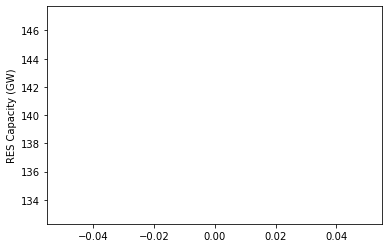

In [18]:
plt.plot(caps)
plt.ylabel('RES Capacity (GW)')

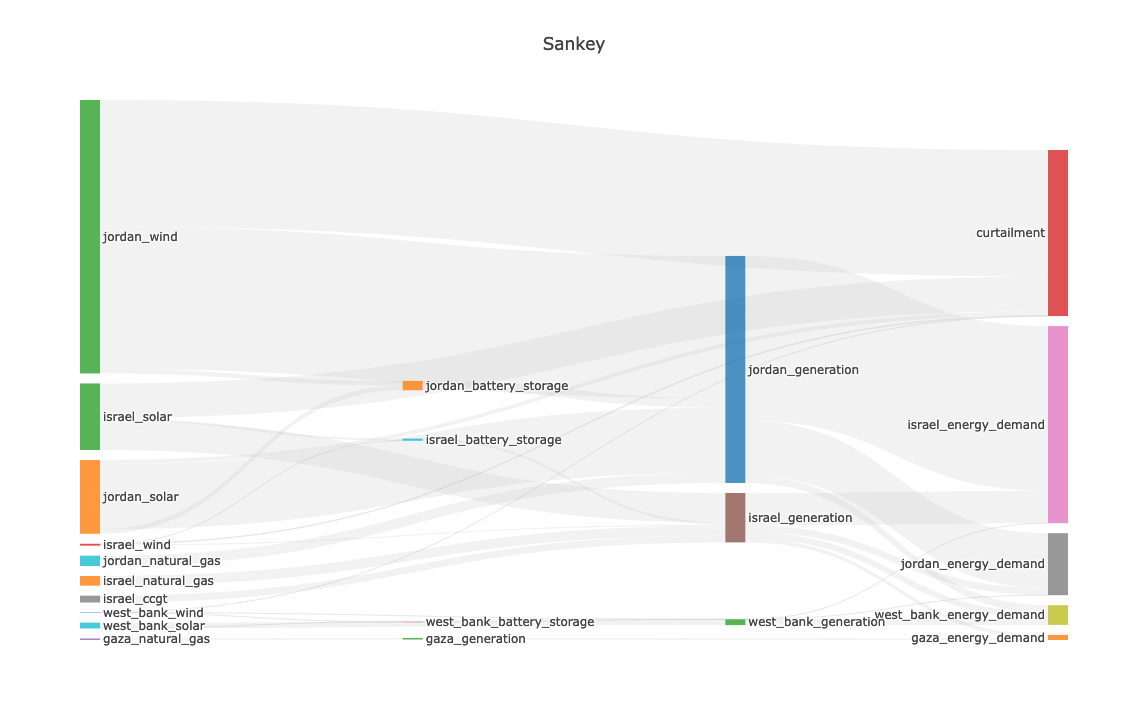

{'data': [{'type': 'sankey',
   'domain': {'x': [0, 1], 'y': [0, 1]},
   'orientation': 'h',
   'valueformat': '.0f',
   'node': {'pad': 10,
    'line': {'color': 'black', 'width': 0},
    'label': 0              egypt_generation
    1          gaza_battery_storage
    2                   gaza_diesel
    3               gaza_generation
    4              gaza_natural_gas
    5                    gaza_solar
    6        israel_battery_storage
    7                   israel_ccgt
    8                   israel_coal
    9                 israel_diesel
    10            israel_generation
    11           israel_natural_gas
    12                 israel_solar
    13                  israel_wind
    14       jordan_battery_storage
    15                  jordan_ccgt
    16                  jordan_coal
    17                jordan_diesel
    18            jordan_generation
    19           jordan_natural_gas
    20                 jordan_shale
    21                 jordan_solar
    22        

In [19]:
results['COO_0.9'].plot_flows_sankey()

In [13]:
results['COO_0.9'].get_capacities()

,node,value,technology,territory
0,israel_wind,739.000000,Wind,Israel
361,israel_solar,26831.999477,Solar,Israel
722,israel_natural_gas,10113.326602,Gas,Israel
1083,israel_diesel,0.000000,Diesel,Israel
1444,israel_coal,0.000000,Coal,Israel
1805,israel_ccgt,3400.000000,Gas,Israel
2166,jordan_wind,82534.596502,Wind,Jordan
2527,jordan_solar,698.000000,Solar,Jordan
2888,jordan_natural_gas,9869.561589,Gas,Jordan
3249,jordan_diesel,0.000000,Diesel,Jordan
